In [2]:
# import block 
from keras.models import Sequential
from scipy.misc import imread
get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.layers import Dense
import pandas as pd
from keras.models import Model

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
from keras.applications.vgg16 import decode_predictions
from keras.utils.np_utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation
from keras.models import load_model
from sklearn.metrics import log_loss
import os

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: Tesla K80 (0000:05:00.0)


In [4]:
# path to files 
file_path = '/home/ppedapen/stl/'
os.chdir(file_path)
os.listdir(file_path)

['class_names.txt',
 'fold_indices.txt',
 'test_X.bin',
 'test_y.bin',
 'train_X.bin',
 'train_y.bin',
 'unlabeled_X.bin',
 'data',
 'vgg16_weights.h5',
 'dl-cl-ly4-1.h5',
 'dl-model.h5']

In [8]:
# functions to access the data 
# image shape
HEIGHT = 96
WIDTH = 96
DEPTH = 3

# size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH
def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels
    
def read_all_images(path_to_data):
    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)
        images = np.reshape(everything, (-1,96, 96,3))
        images = np.transpose(images, (0, 3, 2, 1))
        return images
def read_single_image(image_file):
    """
    CAREFUL! - this method uses a file as input instead of the path - so the
    position of the reader will be remembered outside of context of this method.
    :param image_file: the open file containing the images
    :return: a single image
    """
    image = np.fromfile(image_file, dtype=np.uint8, count=SIZE)
    image = np.reshape(image, (3,96, 96))
    image = np.transpose(image, (2, 1, 0))
    return image



In [9]:
# loading the data 
train_x= read_all_images('train_X.bin')
train_y =  read_labels('train_y.bin')
test_x = read_all_images('test_X.bin')
test_y = read_labels('test_y.bin')

In [10]:
# making sense of the data
train_set_info = dict()
test_set_info = dict()
for i in range(1,11):
    train_set_info[str(i)] = list(train_y).count(i)
    test_set_info[str(i)] = list(test_y).count(i)

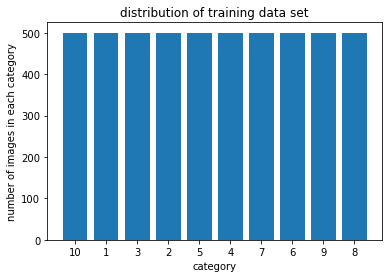

In [11]:
# plots
# I know  x- axis labels are not in assending order, dont know why. 
plt.bar(range(len(train_set_info)), train_set_info.values(), align='center')
plt.xticks(range(len(train_set_info)), train_set_info.keys())
plt.xlabel('category')
plt.ylabel('number of images in each category')
plt.title('distribution of training data set')
plt.show()

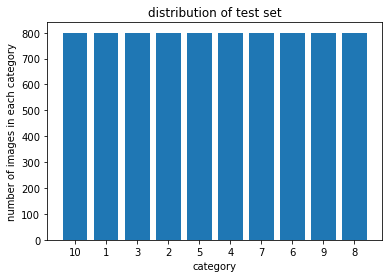

In [12]:
# plot of test data set 
plt.bar(range(len(test_set_info)), test_set_info.values(), align='center')
plt.xticks(range(len(test_set_info)), test_set_info.keys())
plt.xlabel('category')
plt.ylabel('number of images in each category')
plt.title('distribution of test set')
plt.show()

#### test data and training data are uniformly ditributed each class in training data set has 500 images and each class in test set has 800 images

## model builiting using a VVG16 model, I am freezing first 4 layers 

In [13]:
# defining the the model 
def vgg16_model(img_rows, img_cols, channel=1, num_classes=None):
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
    model_vgg16_conv.summary()

    #Create your own input format (here 3x200x200)
    input = Input(shape=(3,96,96),name = 'image_input')

    #Use the generated model 
    output_vgg16_conv = model_vgg16_conv(input)

    #Add the fully-connected layers 
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(4608, activation='relu', name='fc-a')(x)
    x = Dense(2048, activation='relu', name='fc-b')(x)
    x = Dense(1024, activation='relu', name='fc-c')(x)
    x = Dense(512, activation='relu', name='fc-d')(x)
    x = Dense(256, activation='relu', name='fc1')(x)
    x = Dense(100, activation='relu', name='fc2')(x)
    x = Dense(10, activation='softmax', name='predictions')(x)
    
  
  

    #Create your own model 
    model = Model(input=input, output=x)
    
    #To set the first 4 layers to non-trainable (weights will not be updated)
    for layer in model.layers[:4]:
        layer.trainable = False
    # Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    
    
    return model



In [14]:
# encoding arrays 
le = LabelEncoder()
train_y = le.fit_transform(train_y)
train_y=to_categorical(train_y)
train_y=np.array(train_y)


le = LabelEncoder()
test_y = le.fit_transform(test_y)
test_y=to_categorical(test_y)
test_y=np.array(test_y)

In [16]:
# defining parapeters 
img_rows, img_cols = 96, 96 # Resolution of inputs
channel = 3
num_classes = 10 
batch_size = 16 
nb_epoch = 10


In [16]:
# model creation
model = vgg16_model(img_rows, img_cols, channel, num_classes)

model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 3, None, None) 0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 64, None, None 1792        input_3[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 64, None, None 36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 64, None, None 0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [6]:
# run this block to load the pretrained model 
# run only if you want to. else you can tran the model from scratch

# if there is an error message 
'''
ValueError: Optimizer weight shape (64, 3, 3, 3) not compatible with provided weight shape (4608, 2048), 
then you need to remove optimizer_weights , there is code snipet at the end of this file to do that
this error is caused because of a bug in load_model '''

model = load_model('dl-model.h5')

In [17]:
# train the model to fit our data
model.fit(train_x, train_y,batch_size=batch_size,nb_epoch=1,shuffle=True,verbose=1,validation_data=(test_x, test_y))

Train on 5000 samples, validate on 8000 samples
Epoch 1/1
5000/5000 [==============================] - 63s - loss: 1.9059 - acc: 0.3636 - val_loss: 1.5220 - val_acc: 0.4256


In [17]:
# Make predictions
predictions_valid = model.predict(test_x, batch_size=batch_size, verbose=1)

8000/8000 [==============================] - 40s    


In [18]:
#accuracy
temp = np.zeros_like(predictions_valid)
temp[np.arange(len(predictions_valid)), predictions_valid.argmax(1)] = 1
count = 0
for i in range(0, len(temp)):
    if (np.count_nonzero(test_y[i]!=temp[i])  == 0):
        count +=1

accuracy = (float(count)/(len(temp)))
print('accuracy %: ',accuracy*100)


('accuracy %: ', 52.87500000000001)


In [268]:
# save the model if you want to
model.save('dl-cl-ly4-1.h5')  

### do not run the next block unless you want to start an infinity loop. 

In [221]:
# infinity loop  to train the model. 
accuracy =float()
iteration = int()
# you cant set how many times one want to run the loop, that is equal to the number of epoches. I have set infinity loop
# the model will be saved if there is an improved  prediction accuracy 
while(True):
    iteration +=1 
    model.fit(train_x, train_y,batch_size=batch_size,nb_epoch=1,shuffle=True,verbose=1,validation_data=(test_x, test_y))
    predictions_valid = model.predict(test_x, batch_size=batch_size, verbose=1)
    #accuracy
    temp = np.zeros_like(predictions_valid)
    temp[np.arange(len(predictions_valid)), predictions_valid.argmax(1)] = 1
    count = 0
    for i in range(0, len(temp)):
        if (np.count_nonzero(test_y[i]!=temp[i])  == 0):
            count +=1

    accuracy_cal = (float(count)/(len(temp)))
    print('iteration : ',iteration,', accuracy %: ',accuracy_cal*100)
    if accuracy_cal > accuracy:
        print('saving at iter::: ' ,iteration )
        accuracy = accuracy_cal
        model.save('dl-model.h5')
        
        
    
    

Train on 5000 samples, validate on 8000 samples
Epoch 1/1
8000/8000 [==============================] - 39s    
('iteration : ', 1, ', accuracy %: ', 48.112500000000004)
('saving at iter::: ', 1)
Train on 5000 samples, validate on 8000 samples
Epoch 1/1
8000/8000 [==============================] - 40s    
('iteration : ', 2, ', accuracy %: ', 50.0375)
('saving at iter::: ', 2)
Train on 5000 samples, validate on 8000 samples
Epoch 1/1
8000/8000 [==============================] - 40s    
('iteration : ', 3, ', accuracy %: ', 50.349999999999994)
('saving at iter::: ', 3)
Train on 5000 samples, validate on 8000 samples
Epoch 1/1
8000/8000 [==============================] - 40s    
('iteration : ', 4, ', accuracy %: ', 47.4625)
Train on 5000 samples, validate on 8000 samples
Epoch 1/1
8000/8000 [==============================] - 39s    
('iteration : ', 5, ', accuracy %: ', 49.3625)
Train on 5000 samples, validate on 8000 samples
Epoch 1/1
8000/8000 [==============================] - 39s    

8000/8000 [==============================] - 42s     ETA: 
('iteration : ', 57, ', accuracy %: ', 52.775000000000006)
Train on 5000 samples, validate on 8000 samples
Epoch 1/1
8000/8000 [==============================] - 41s    
('iteration : ', 58, ', accuracy %: ', 52.775000000000006)
Train on 5000 samples, validate on 8000 samples
Epoch 1/1
8000/8000 [==============================] - 40s    
('iteration : ', 59, ', accuracy %: ', 52.775000000000006)
Train on 5000 samples, validate on 8000 samples
Epoch 1/1
8000/8000 [==============================] - 43s    
('iteration : ', 60, ', accuracy %: ', 52.7625)
Train on 5000 samples, validate on 8000 samples
Epoch 1/1
8000/8000 [==============================] - 42s    
('iteration : ', 61, ', accuracy %: ', 52.7625)
Train on 5000 samples, validate on 8000 samples
Epoch 1/1
8000/8000 [==============================] - 40s    
('iteration : ', 62, ', accuracy %: ', 52.775000000000006)
Train on 5000 samples, validate on 8000 samples
Epoch 

KeyboardInterrupt: 

#### intrupted after running nearly 100 epochs and saved the weights. I got a maximum accurary of 52.85 % 

## visuallizing results 

In [19]:

# imports
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys

In [20]:
# reversing onehot encoding of predicted values 
li = []
for i in range(0, len(temp)):
    val=np.where(temp[i])[0][0]+1
    li.append(val)

In [22]:
# this is the confussion matrix 

from sklearn.metrics import confusion_matrix
test_y = read_labels('test_y.bin')
mat = confusion_matrix(li, test_y)

true_val = []
for i in range(0,10):
    true_val.append(mat[i,i])

test_predicted_true = dict()
test_predicted_false = dict()
for i in range(0,10):
    test_predicted_true[str(i+1)] = true_val[i]
    test_predicted_false[str(i+1)] = 800- true_val[i]
    

print(mat)

    

[[535  43  39  10  25  12  17   2  85  51]
 [ 34 373  11  95  38  64  25 107  11   3]
 [ 36   6 542  17   4   6  14   2  45 106]
 [  7 100  20 342  92 122  36 118  26  14]
 [  9  56   5  91 426  85  67  73   4   8]
 [ 13  68  16  86  41 252 101 111   3  15]
 [  5  16  10  25  88 124 453  62   3  15]
 [  4 130   7 115  70 118  55 319   0   5]
 [111   5  34  11   8   9   3   3 519 114]
 [ 46   3 116   8   8   8  29   3 104 469]]


[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10] # see this a lable 

if there is any inconvenience to read the matrix 
refere this link http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html


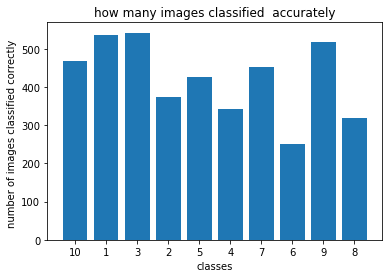

x axis shows the classes  of images in this data set and Y axis shows how many of them are classifed accurately belonging to a particular class


In [30]:
# plots
# how many correted accurately 
plt.bar(range(len(test_predicted_true)), test_predicted_true.values(), align='center')
plt.xticks(range(len(test_predicted_true)), test_predicted_true.keys())
plt.xlabel('classes')
plt.ylabel('number of images classified correctly ')
plt.title('how many images classified  accurately')
plt.show()
print("x axis shows the classes  of images in this data set and Y axis shows how many of them are \
classifed accurately belonging to a particular class")

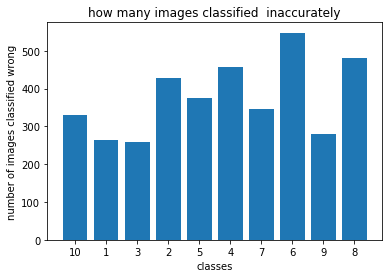

x axis shows the classes  of images in this data set and Y axis shows how many of them are classifed inaccurately belonging to a particular class


In [31]:
# how many false
plt.bar(range(len(test_predicted_false)), test_predicted_false.values(), align='center')
plt.xticks(range(len(test_predicted_false)), test_predicted_false.keys())
plt.xlabel('classes')
plt.ylabel('number of images classified wrong')
plt.title('how many images classified  inaccurately')
plt.show()
print("x axis shows the classes  of images in this data set and Y axis shows how many of them are \
classifed inaccurately belonging to a particular class")

In [41]:
def plot_clasfied(class_label,label_name):
    plt.plot(range(1,11),  mat[class_label-1,:], 'ro')
    plt.title('how class label : '+ str(class_label)+' is clasified' )
    plt.ylabel('numbers of times')
    plt.xticks(np.arange(1, 11, 1.0))
    plt.show()
    print('class label', class_label ,' is :',label_name)
    print(" the plot shows how images belonging to a particular class got \
    classified by our prediction model to different classes ")
    

In [42]:
lables={'bird': 2,
 'car': 3,
 'cat': 4,
 'deer': 5,
 'dog': 6,
 'horse': 7,
 'monkey': 8,
 'plane': 1,
 'ship': 9,
 'truck': 10}

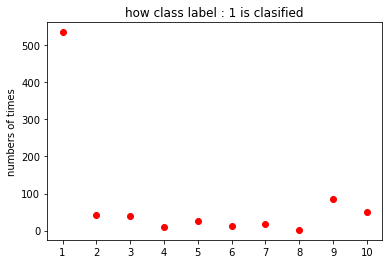

('class label', 1, ' is :', 'plane')
 the plot shows how images belonging to a particular class got classified by our prediction model to different classes 


In [43]:
plot_clasfied(1,'plane')


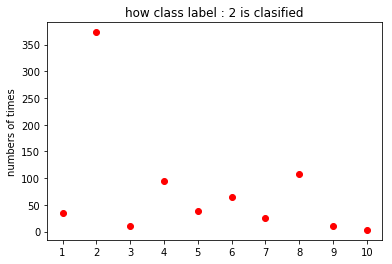

('class label', 2, ' is :', 'Bird')
 the plot shows how images belonging to a particular class got classified by our prediction model to different classes 


In [44]:
plot_clasfied(2,'Bird')

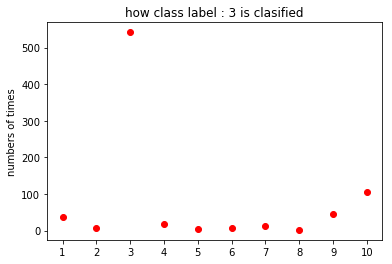

('class label', 3, ' is :', 'Car')
 the plot shows how images belonging to a particular class got classified by our prediction model to different classes 


In [45]:
plot_clasfied(3,'Car')
# we can see model is getting more confused with label 10 : truck 

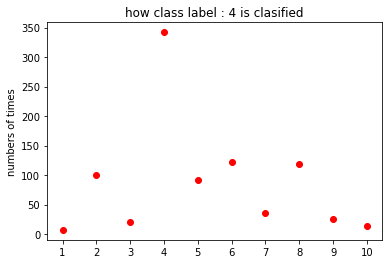

('class label', 4, ' is :', 'Cat')
 the plot shows how images belonging to a particular class got classified by our prediction model to different classes 


In [46]:
plot_clasfied(4,'Cat') 
# we can see our model is getting confused more with other animals as they share similar features like Fur, eyes, legs 


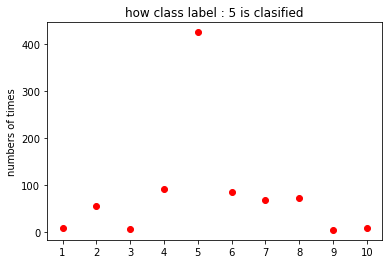

('class label', 5, ' is :', 'Deer')
 the plot shows how images belonging to a particular class got classified by our prediction model to different classes 


In [47]:
plot_clasfied(5,'Deer')

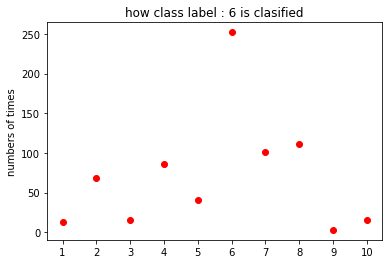

('class label', 6, ' is :', 'Dog')
 the plot shows how images belonging to a particular class got classified by our prediction model to different classes 


In [48]:
plot_clasfied(6,'Dog')

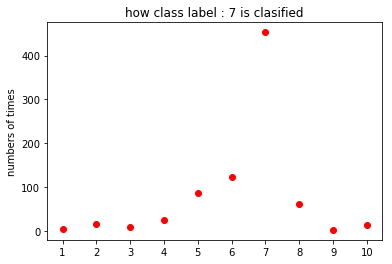

('class label', 7, ' is :', 'Horse')
 the plot shows how images belonging to a particular class got classified by our prediction model to different classes 


In [49]:
plot_clasfied(7,'Horse')

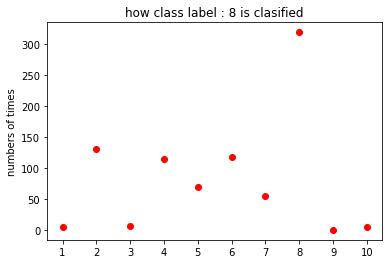

('class label', 8, ' is :', 'Monkey')
 the plot shows how images belonging to a particular class got classified by our prediction model to different classes 


In [50]:
plot_clasfied(8,'Monkey')

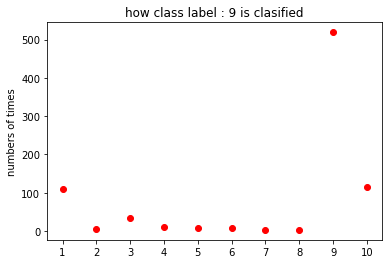

('class label', 9, ' is :', 'Ship')
 the plot shows how images belonging to a particular class got classified by our prediction model to different classes 


In [51]:
plot_clasfied(9,'Ship')

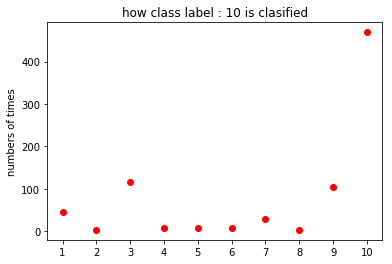

('class label', 10, ' is :', 'Truck')
 the plot shows how images belonging to a particular class got classified by our prediction model to different classes 


In [52]:
plot_clasfied(10,'Truck')
# got more confused with car 

In [ ]:
# if you want to visualize the images in the data set I have uploaded a python file to my github repo

In [5]:
# remove optimizer_weights, run this if value error: Can't load_model with Optimizer weight shape not compatable 
import h5py
f = h5py.File('dl-model.h5', 'r+')
del f['optimizer_weights']
f.close()

### the best  image classification models (winner's of imagenet competition )will be around 86 % as per what I read, I am sure we can imporve my model. I personally could not imporve any further as my understanind of CNN is limited for now, hopefully  in future I will have the knowlege to do better. 

#### the data set we are provided are of 96*96 size, I feel the resoultion is quite low, if we were provided images of better quality that our accuracy of our model may imporve.

#### this model is not good at classifying animal's with fur, as most the animals in the given data set share similar features like they have fur, big eyes, 4 legs. to solve this issue we need  more images of these animals of high resoultion. 

#### I found this article quite useful to build this model 
https://www.analyticsvidhya.com/blog/2017/06/transfer-learning-the-art-of-fine-tuning-a-pre-trained-model/

there is a bug in load_model(), I have addressed it though.  I took lot of time to fix it. 